In [1]:
import sys
import os
import getpass

# Path to where your CaloQVAE dir is
upper_dir = 'WLVAE'
# Path to where your CaloQVAE dir is
os.chdir('/home/' + getpass.getuser() + f'/{upper_dir}' + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + f'/{upper_dir}' + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + f'/{upper_dir}/')

#external libraries
import os

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())

In [2]:
xgen_samples = torch.load('/home/' + getpass.getuser() + f'/{upper_dir}/CaloQVAE/xgen_samples.pt')
xrecon_samples = torch.load('/home/' + getpass.getuser() + f'/{upper_dir}/CaloQVAE/xrecon_samples.pt')
xtarget_samples = torch.load('/home/' + getpass.getuser() + f'/{upper_dir}/CaloQVAE/xtarget_samples.pt')
entarget_samples = torch.load('/home/' + getpass.getuser() + f'/{upper_dir}/CaloQVAE/entarget_samples.pt')

In [3]:
def measure_single_granularity(data_tensor_1, index):
    """
    Measure the granularity of a calorimeter image given as a 1D array using PyTorch.
    
    Parameters:
    data (array-like): 1D array representing the calorimeter image.
    
    Returns:
    float: A measure of the granularity.
    """
    # Calculate the differences between consecutive elements
#     diffs_1 = (data_tensor_1[:,index:] - data_tensor_1[:,:-index])/torch.mean(data_tensor_1[:,:-index], dim = 1, keepdim=True)
    diffs_1 = (data_tensor_1[:,index:] - data_tensor_1[:,:-index])
#     std_g = torch.std(diffs_1, dim = 1)
    return diffs_1

In [4]:
def granularity_matrix(x, off_set = 0.0001):
    """
    Measure the granularity of a calorimeter image given as a 1D array using PyTorch.
    """
    mean_value = torch.mean(x,dim = 0)
    # Calculate the differences between consecutive elements
    calibration = torch.ones_like(mean_value) * off_set
    granularity_matrix = (x)/(mean_value+calibration)
    act = nn.ReLU()
    granularity_matrix = act(granularity_matrix)
    train_matrix = act(torch.log10(granularity_matrix/off_set + torch.ones_like(granularity_matrix)))
    return granularity_matrix, train_matrix

In [5]:
def re_mask_activations(train_matrix, off_set = 0.0001):
    act = nn.ReLU()
    re_mask = act((10**train_matrix-torch.ones_like(train_matrix))*off_set)
    return re_mask

In [6]:
granularity_target = measure_single_granularity(xtarget_samples,9)
granularity_sample = measure_single_granularity(xgen_samples,9)
granularity_recon = measure_single_granularity(xrecon_samples,9)

In [7]:
granularity_target.shape

torch.Size([10000, 6471])

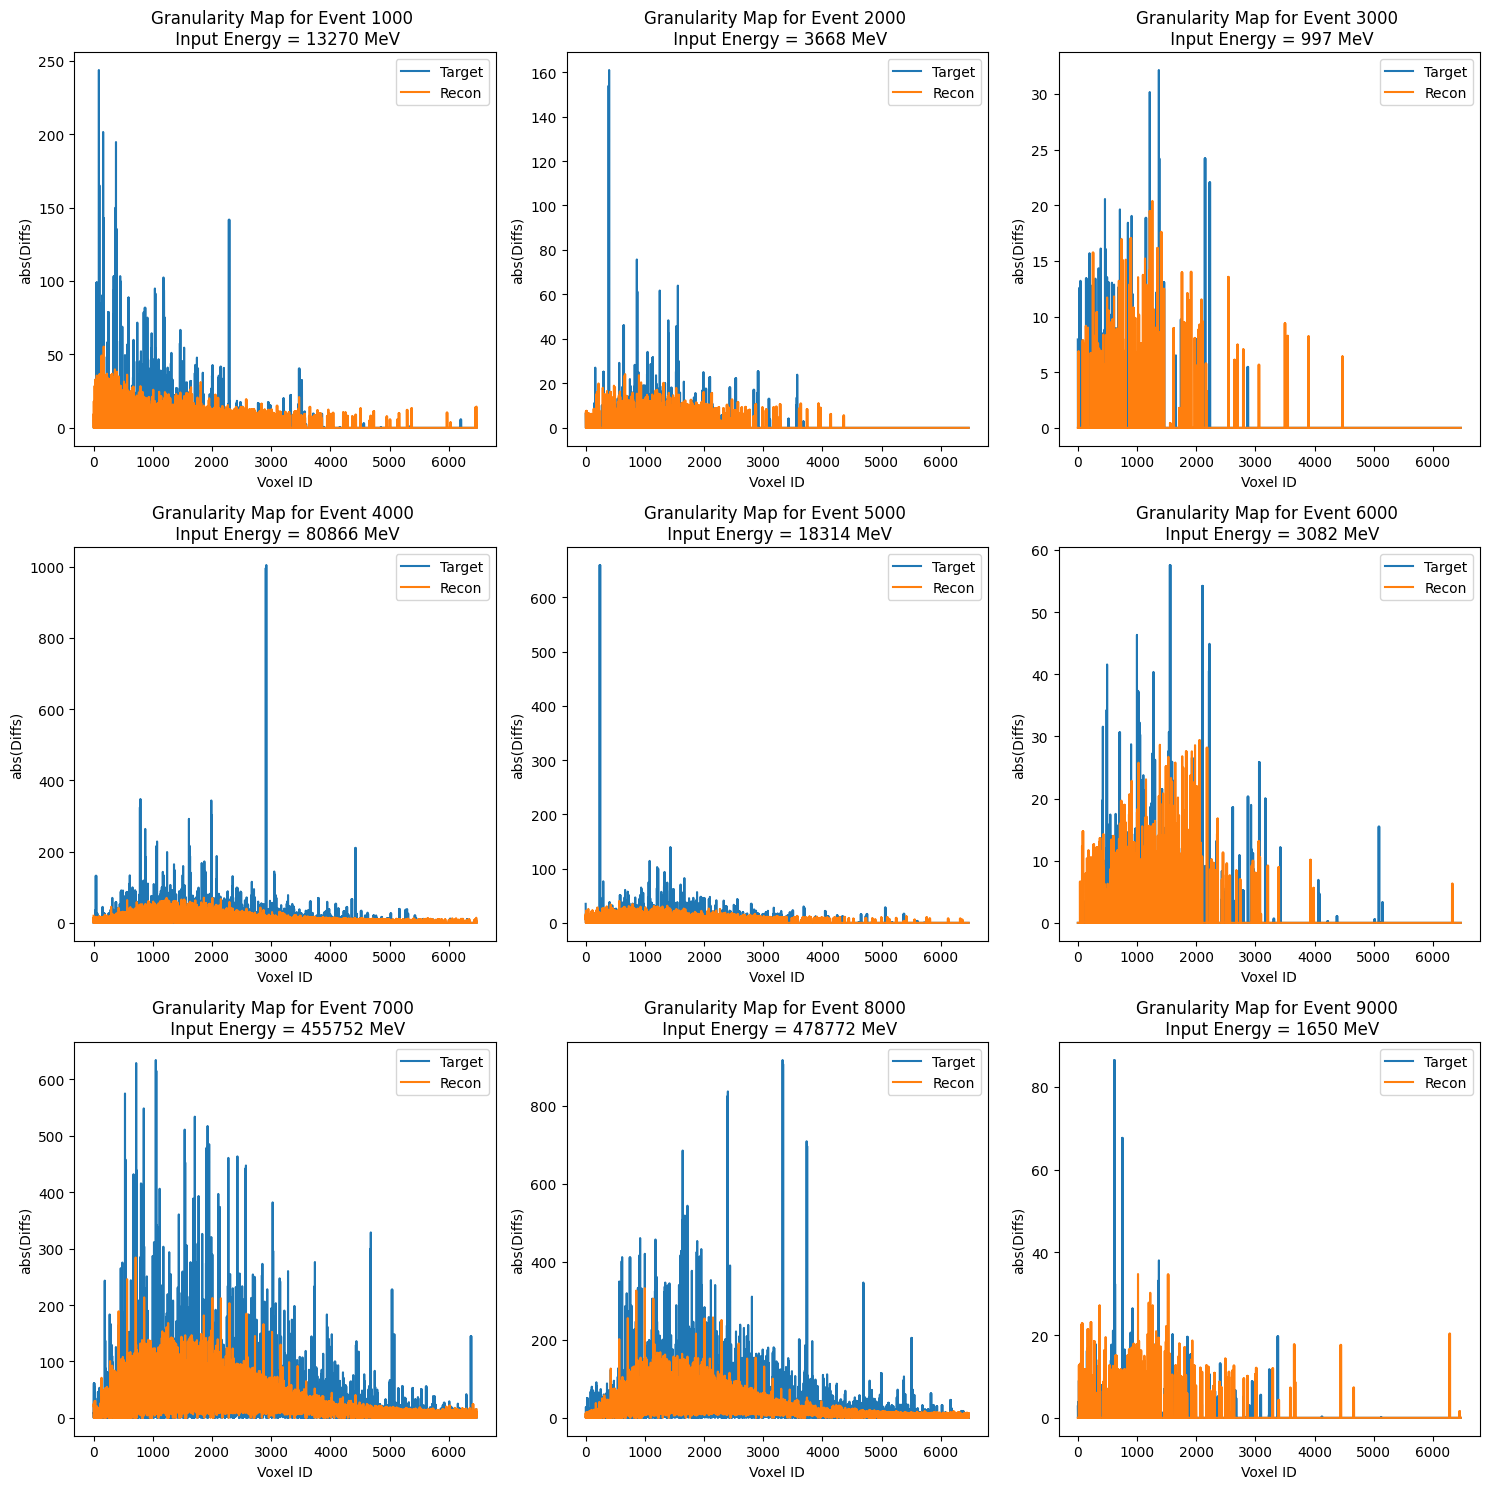

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
indices = range(1000, 10001, 1000)  # 从1000到9000，每隔1000

for ax, i in zip(axes.flatten(), indices):
    ax.plot(abs(granularity_target[i]), label='Target')
    ax.plot(abs(granularity_recon[i]), label='Recon')
    total_energy = int((torch.sum(xtarget_samples[i])+torch.sum(xrecon_samples[i]))/2)
    ax.set_xlabel('Voxel ID')
    ax.set_ylabel('abs(Diffs)')
    ax.legend()
    ax.set_title(f'Granularity Map for Event {i} \n Input Energy = {total_energy} MeV')

plt.tight_layout()
plt.show()

In [9]:
std_target = torch.std(granularity_target, dim =1)
std_recon = torch.std(granularity_recon, dim =1)

In [10]:
std_target.shape

torch.Size([10000])

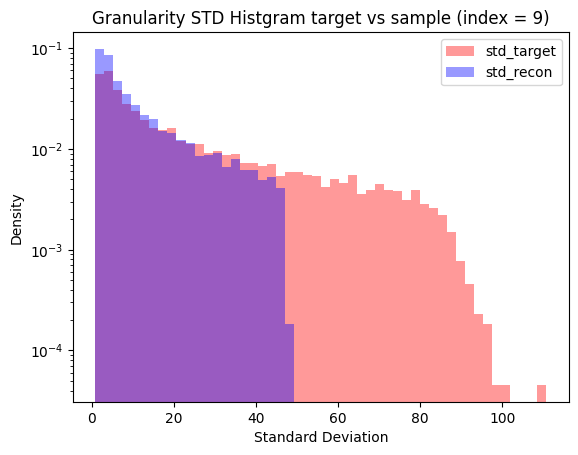

In [12]:
combined_data = np.concatenate((std_target, std_recon))
bins = np.histogram_bin_edges(combined_data, bins=50)
plt.hist(std_target, log=True, color = 'red', bins=bins,alpha = 0.4, label = "std_target", density = True)
plt.hist(std_recon, log=True, color = 'blue', alpha = 0.4, bins=bins, label = "std_recon", density = True)
plt.xlabel('Standard Deviation')
plt.ylabel('Density')
plt.legend()
plt.title("Granularity STD Histgram target vs sample (index = 9)")
plt.show()

In [13]:
index = []
error_target_list = []
error_recon_list = []
ratio_list = []
for i in range(1, 30):
    error_recon = torch.mean(torch.std(measure_single_granularity(xrecon_samples, i),dim=0))
    error_target = torch.mean(torch.std(measure_single_granularity(xtarget_samples, i),dim=0))
    ratio = error_target/error_recon
    error_recon_list.append(error_recon)
    error_target_list.append(error_target)
    ratio_list.append(ratio)
    index.append(i)

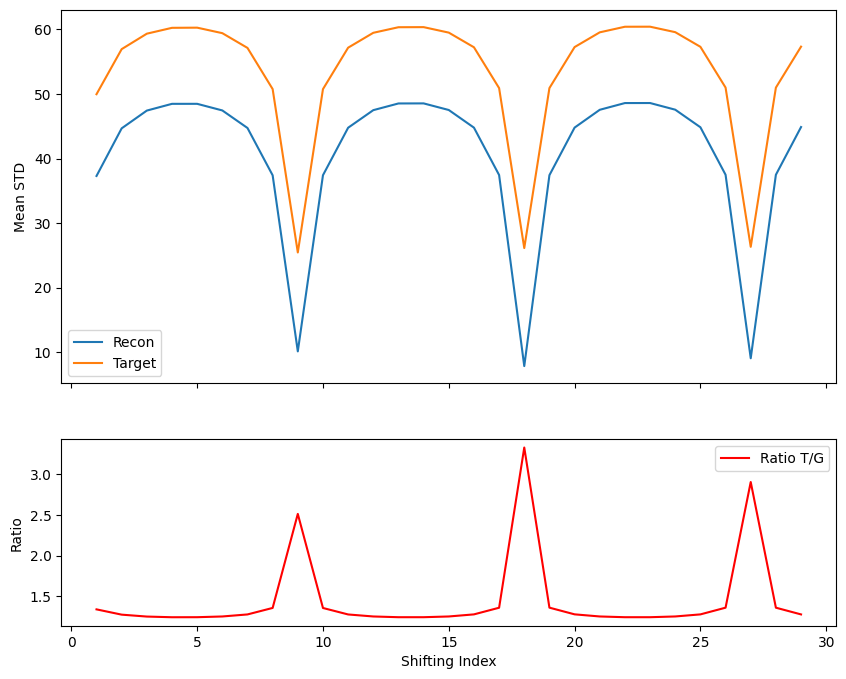

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

# 在第一个子图中绘制 error_gen_list 和 error_target_list
ax1.plot(index, error_recon_list, label='Recon')
ax1.plot(index, error_target_list, label='Target')
ax1.legend()
ax1.set_ylabel('Mean STD')

# 在第二个子图中绘制 ratio_list
ax2.plot(index, ratio_list, label='Ratio T/G', color='r')
ax2.legend()
ax2.set_xlabel('Shifting Index')
ax2.set_ylabel('Ratio')

plt.show()